# Combined Notebook

### ~ Nikhil Roy, Ayaan Siddiqui, Brayden Yan

For our project, we picked three factors that we thought were most important for the determination of a good neighborhood. The Pittsburgh SNAP Census datasets (2010) had all the information we needed, indexed by neighborhood. The factors we chose were:

1. Natural Environmental Conditions
2. Public Safety
2. Housing

In [13]:
import pandas as pd
import numpy as np
import geopandas as geo
import seaborn as sb
%matplotlib inline
import matplotlib.pyplot as plt
neighborhoods = geo.read_file("pittsburgh-pa-neighborhoods.shp")
public_safety = pd.read_csv("Public Safety 2010.csv", index_col="Neighborhood")
nat = pd.read_csv("Natural Environment Conditions 2010.csv", index_col = "Neighborhood")
house = pd.read_csv("Housing 2010.csv")

## Factor 1 - Public Safety ##

#### For our next metric, we are trying to find out which neighborhood is the safest. We will start off by figuring out which neighborhoods are the most theft-free and which are the most drug-free. With these two criteria, we will classify which neighborhood comes on top for "the most safe neighborhood".
---

### Critera one: Most theft-free

In [32]:
burglaries = public_safety.groupby("Neighborhood").sum()['#Burglary (2010)']
burglaries

Neighborhood
Allegheny Center        8
Allegheny West          6
Allentown              48
Arlington              15
Arlington Heights       5
                       ..
Upper Lawrenceville    24
West End                7
West Oakland           14
Westwood               17
Windgap                 8
Name: #Burglary (2010), Length: 90, dtype: int64

In [33]:
auto_theft = public_safety.groupby("Neighborhood").sum()['#Auto Theft (2010)']
auto_theft

Neighborhood
Allegheny Center        5
Allegheny West          4
Allentown              11
Arlington               7
Arlington Heights       3
                       ..
Upper Lawrenceville    12
West End                3
West Oakland            8
Westwood                6
Windgap                 7
Name: #Auto Theft (2010), Length: 90, dtype: int64

In [34]:
robbery = public_safety.groupby("Neighborhood").sum()['#Robbery (2010)']
robbery

Neighborhood
Allegheny Center        9
Allegheny West          4
Allentown              15
Arlington               8
Arlington Heights       4
                       ..
Upper Lawrenceville    12
West End                2
West Oakland           13
Westwood                1
Windgap                 4
Name: #Robbery (2010), Length: 90, dtype: int64

## Lets combine them altogether to make one "Theft" score for each neighborhood

In [35]:
theft = pd.concat([burglaries, auto_theft, robbery], axis = 1, join='inner')
theft["Thefts"] = np.nan
for x in range(len(theft)):
    theft.iloc[x,3] = 0
    for y in range(3):
        theft.iloc[x,3] += theft.iloc[x,y]
theft = theft.sort_values(by=['Thefts'], ascending=True)
theft

,#Burglary (2010),#Auto Theft (2010),#Robbery (2010),Thefts
Neighborhood,,,,
Fairywood,1,0,0,1.0
Chateau,0,2,1,3.0
New Homestead,1,2,0,3.0
Ridgemont,3,0,0,3.0
Chartiers City,2,2,0,4.0
...,...,...,...,...
Bloomfield,70,36,45,151.0
Mount Washington,115,38,22,175.0
South Side Flats,74,56,52,182.0


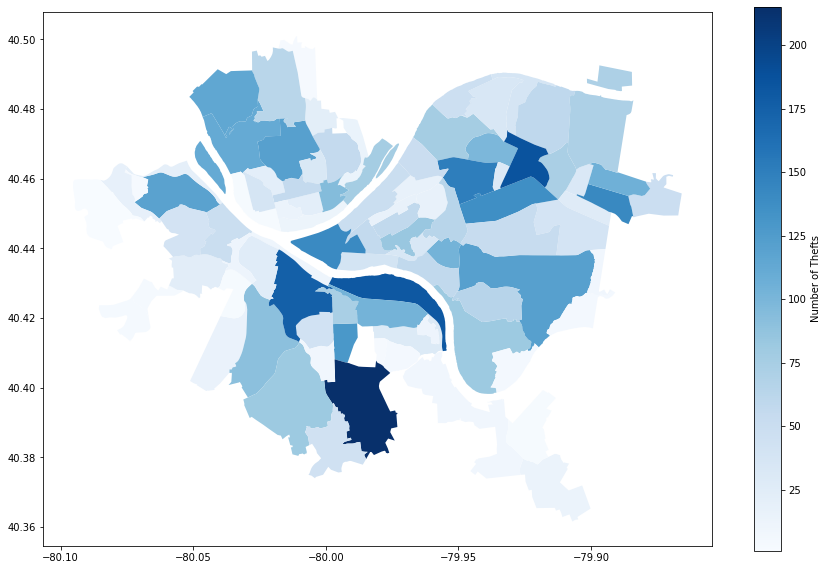

In [36]:
theft_graph = theft.groupby("Neighborhood").sum()['Thefts']
theft_map = neighborhoods.merge(theft_graph, how='left', left_on='hood', right_on='Neighborhood')
theft_map.plot(column='Thefts',
                  cmap='Blues',
                  figsize=(15,10), 
                  legend=True,
                  legend_kwds={'label':"Number of Thefts"}
                  )

## Fairywood is looking good! 
---
### Criteria two: Drug-free
---

In [37]:
drug_vio = public_safety.groupby("Neighborhood").sum()['#Drug Violations (2010)']
drug_vio = drug_vio.sort_values(ascending=False)
drug_vio

Neighborhood
Knoxville           113
Middle Hill         102
Crawford-Roberts     90
Perry South          87
East Allegheny       73
                   ... 
Swisshelm Park        0
East Carnegie         0
Fairywood             0
St. Clair             0
Lincoln Place         0
Name: #Drug Violations (2010), Length: 90, dtype: int64

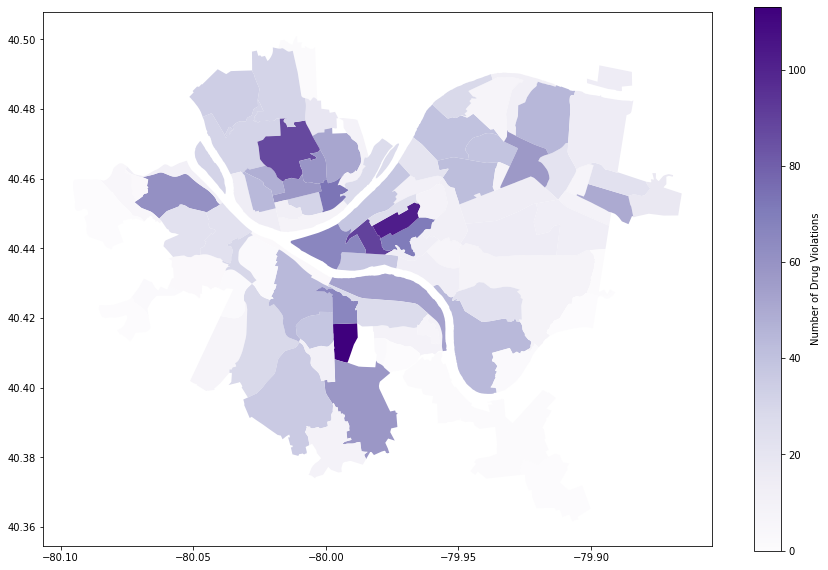

In [38]:
drug_map = neighborhoods.merge(drug_vio, how='left', left_on='hood', right_on='Neighborhood')
drug_map.plot(column='#Drug Violations (2010)',
                  cmap='Purples',
                  figsize=(15,10), 
                  legend=True,
                  legend_kwds={'label':"Number of Drug Violations"}
                  )

---

### Combined Safety Score

In [39]:
thefts = theft.groupby("Neighborhood").sum()['Thefts']
best_neigh = pd.concat([thefts, drug_vio], axis = 1, join='inner')
best_neigh["Crime Scores"] = np.nan
for x in range(len(best_neigh)):
    best_neigh.iloc[x,2] = 0
    for y in range(2):
        best_neigh.iloc[x,2] += best_neigh.iloc[x,y]
best_neigh = best_neigh.sort_values(by=['Crime Scores'], ascending=True)
best_neigh

,Thefts,#Drug Violations (2010),Crime Scores
Neighborhood,,,
Fairywood,1.0,0,1.0
New Homestead,3.0,1,4.0
East Carnegie,5.0,0,5.0
Ridgemont,3.0,2,5.0
Summer Hill,4.0,1,5.0
...,...,...,...
Mount Washington,175.0,44,219.0
South Side Flats,182.0,53,235.0
Knoxville,129.0,113,242.0


## Fairywood takes the **W!**

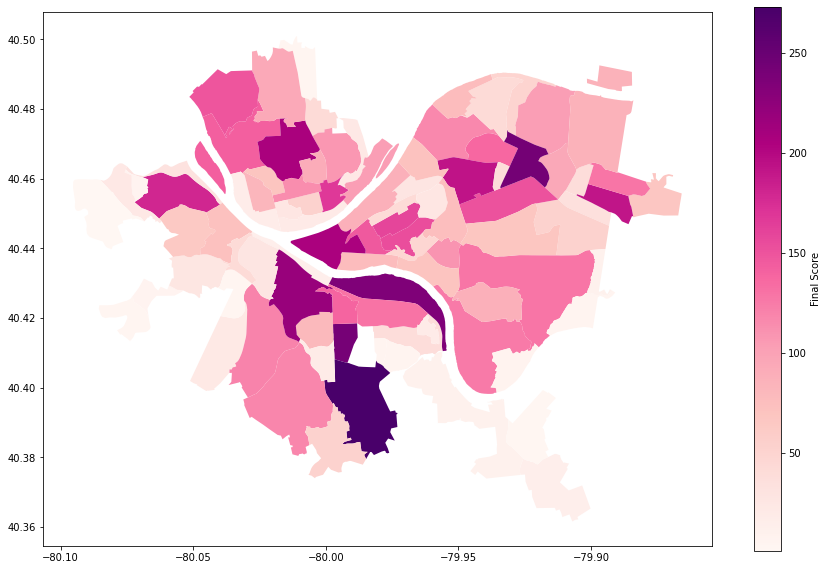

In [40]:
final_graph = best_neigh.groupby("Neighborhood").sum()['Crime Scores']
final_map = neighborhoods.merge(final_graph, how='left', left_on='hood', right_on='Neighborhood')
final_map.plot(column='Crime Scores',
                  cmap='RdPu',
                  figsize=(15,10), 
                  legend=True,
                  legend_kwds={'label':"Final Score"}
                  )

---

## Factor 2 - Housing

#### The dataset:

In [41]:
import pandas as pd
import numpy as np
import geopandas as geo
%matplotlib inline
import matplotlib.pyplot as plt
data = pd.read_csv("Housing 2010.csv", 
                                       index_col="Neighborhood")
weights = pd.read_csv("weights.csv")
data.head(10)

# % Occupied Units
# Median Home Value
# Est. Avg. Years of Residence

,Sector #,Population (2010),Total # Units (2000),Total # Units (2010),% Occupied Units (2010),% Vacant Units (2010),# Occupied Units (2010),% Owner Occupied Units (2010),% Renter Occupied Units (2010),Est. Avg. Yrs. of Residence (2010),...,% Units Built before 1939,Median Home Value (2000),Med. Val. ('00 in '10 Dollars),Median Home Value (2010),% Change Real Value 2000-2010,Median Sale Price (2010),# Sales Counted (2010),Foreclosures (2008),Foreclosures (2010),% of all Housing Units Foreclosed (2010)
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Allegheny Center,3,933,675,1052,0.515209,0.484791,535,0.100935,0.899065,0.0,...,0.012821,86500.0,109535.000000,136300.0,0.244351,NaN,0,0,0,0.000000
Allegheny West,3,462,390,355,0.749296,0.250704,203,0.182266,0.817734,15.0,...,0.574468,159700.0,202228.202312,123600.0,-0.388809,309940.0,7,0,1,0.002817
Allentown,6,2500,1505,1291,0.800155,0.199845,953,0.591815,0.408185,5.0,...,0.628886,34300.0,43434.109827,42200.0,-0.028413,8500.0,70,27,11,0.008521
Arlington,7,1869,880,886,0.865688,0.134312,754,0.653846,0.346154,11.0,...,0.723205,38800.0,49132.462428,44200.0,-0.100391,15397.0,34,12,13,0.014673
Arlington Heights,7,244,557,148,0.912162,0.087838,139,0.187050,0.812950,2.0,...,0.092391,45000.0,56983.526012,64400.0,0.130151,NaN,0,0,0,0.000000
Banksville,5,4144,2203,2118,0.954202,0.045798,2093,0.498806,0.501194,5.0,...,0.046419,87200.0,110421.410405,110900.0,0.004334,101430.5,40,7,5,0.002361
Bedford Dwellings,15,1202,1049,746,0.872654,0.127346,695,0.076259,0.923741,2.0,...,0.385902,17200.0,21780.369942,81100.0,2.723536,200.0,1,0,1,0.001340
Beechview,5,7974,4048,3939,0.892612,0.107388,3518,0.587265,0.412735,6.0,...,0.426939,56150.0,71102.777457,72400.0,0.018244,36067.5,128,64,40,0.010155
Beltzhoover,6,1925,1298,1085,0.734562,0.265438,849,0.734982,0.265018,17.0,...,0.673640,34000.0,43054.219653,36000.0,-0.163845,2744.0,39,12,11,0.010138


### Occupied Units Analysis
There are a few things required to be done before the analysis of the first column, percentage of occupied units, can be analyzed. Firstly, the percentage symbol of each cell from this column is stripped away using rstrip() and the data is converted from a string to a float. This column is now numerical.

Next, a new dataframe called "units" is created which consists of two columns: the names of the Pittsburgh neighborhoods and the numerical values of the percentage of occupied units.

The mean is calculated, converted to a float, and saved to the variable, "mean".

A new dataframe is created, called, "units_df", which is simply a replica of the data from units. Next, a new, blank column is created in units_df, called, "Falls Above Avg Percentage Occupied Units?".

Now, each cell is compared to the mean. If the data is above the mean, it gets assigned "Yes" in the "Falls Above Avg Percentage Occupied Units?" column. Otherwise, if the data is below the mean, it gets assigned "No" in this column.

Another new, blank column is now created in units_df. It is called, "Occupied Units Points", which will store the score (aka points) that each cell has. This score is calculated in the code that follows. Basically, all the cells which had "No" in the "Falls Above Avg Percentage Occupied Units?" column were assigned a score of 0. All the cells which had "Yes" were first sorted in descending order, and then they were counted. There were 52 cells assigned "Yes". The weight for Percentage Occupied Units was roughly 3.68. So each cell was assigned a score by multiplying its position with 3.68. For example, Chateau did best for percentage occupied units, so its score was 52 * 3.68 = 191.3.

Lastly, the values of percentage occupied units are sorted in descending order in units_df and the first 10 elements of the dataframe are printed.

There are a few things required to be done before the analysis of the first column, percentage of occupied units, can be analyzed. Firstly, the percentage symbol of each cell from this column is stripped away using rstrip() and the data is converted from a string to a float. This column is now numerical.

Next, a new dataframe called "units" is created which consists of two columns: the names of the Pittsburgh neighborhoods and the numerical values of the percentage of occupied units.

The mean is calculated, converted to a float, and saved to the variable, "mean".

A new dataframe is created, called, "units_df", which is simply a replica of the data from units. Next, a new, blank column is created in units_df, called, "Falls Above Avg Percentage Occupied Units?".

Now, each cell is compared to the mean. If the data is above the mean, it gets assigned "Yes" in the "Falls Above Avg Percentage Occupied Units?" column. Otherwise, if the data is below the mean, it gets assigned "No" in this column.

Another new, blank column is now created in units_df. It is called, "Occupied Units Points", which will store the score (aka points) that each cell has. This score is calculated in the code that follows. Basically, all the cells which had "No" in the "Falls Above Avg Percentage Occupied Units?" column were assigned a score of 0. All the cells which had "Yes" were first sorted in descending order, and then they were counted. There were 52 cells assigned "Yes". The weight for Percentage Occupied Units was roughly 3.68. So each cell was assigned a score by multiplying its position with 3.68. For example, Chateau did best for percentage occupied units, so its score was 52 * 3.68 = 191.3.

Lastly, the values of percentage occupied units are sorted in descending order in units_df and the first 10 elements of the dataframe are printed.

In [42]:
# % Occupied Units

count = 0
for x in data["% Occupied Units (2010)"]:
     x = str(x).rstrip('%')
     data.iloc[count, 4] = float(x)
     count+=1

units = data.sort_values(by=['% Occupied Units (2010)'], ascending = False).iloc[0:, 4:5]
    
mean = float(units.mean())
units_df = pd.DataFrame(units)

units_df["Falls Above Avg Percentage Occupied Units?"] = np.nan

c = 0
for x in range(len(units)):
    temp = units.iloc[x,0]
    if temp > mean:
        units_df.iloc[x,1] = "Yes"
        c+=1
    else:
        units_df.iloc[x,1] = "No"

units_df["Occupied Units Points"] = np.nan

for x in range(len(units_df)):
    if(c-x > 0):
        units_df.iloc[x,2] = (c-x)*weights.iloc[len(weights)-1, 4]
    else:
        units_df.iloc[x,2] = 0

units_df = units_df.sort_values(by=["% Occupied Units (2010)"], ascending=False)
units_df.head(8)

,% Occupied Units (2010),Falls Above Avg Percentage Occupied Units?,Occupied Units Points
Neighborhood,,,
Chateau,1.000000,Yes,233.701149
Swisshelm Park,0.963200,Yes,229.206897
Ridgemont,0.958716,Yes,224.712644
Oakwood,0.954466,Yes,220.218391
Banksville,0.954202,Yes,215.724138
Regent Square,0.951983,Yes,211.229885
Point Breeze,0.951269,Yes,206.735632
Glen Hazel,0.947791,Yes,202.241379


The map represents the percentage of occupied units for each neighborhood in Pittsburgh. The map was created by merging the units table we previously created with the shape file of the Pittsburgh map.

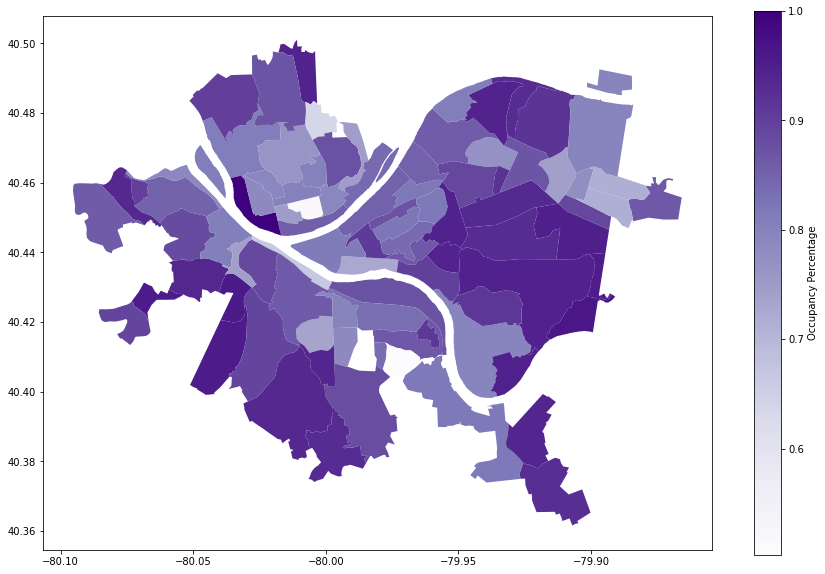

In [43]:
occ_series = units.groupby("Neighborhood").sum()['% Occupied Units (2010)']
neighborhoods = geo.read_file("pittsburgh-pa-neighborhoods.shp")
occ_map = neighborhoods.merge(occ_series, how='left', left_on='hood', right_on='Neighborhood')
occ_map.plot(column='% Occupied Units (2010)',
                  cmap='Purples',
                  figsize=(15,10), 
                  legend=True,
                  legend_kwds={'label':"Occupancy Percentage"})


---
## Median Home Value Analysis
The same process was repeated for median home value: the values were made numerical by removing the percentage symbol and commas, these values were put into a units table, the mean was calculated, and finally a score was given to the data by multiplying its position by the weight for median home value.

In [44]:
# Median Home Value

count = 0
for x in data["Median Home  Value (2010)"]:
    x = str(x).replace('$','')
    x = str(x).replace(',','')
    data.iloc[count, 20] = float(x)
    count+=1
    
mhv_units = data.sort_values(by=["Median Home  Value (2010)"], ascending=False).iloc[0:, 20:21]

mhv_mean = float(mhv_units.mean())

mhv_df = pd.DataFrame(mhv_units)
mhv_df["Below Mean?"] = np.nan

c = 0
for x in range(len(mhv_units)):
    mhv_temp = mhv_units.iloc[x,0]
    if mhv_temp < mhv_mean:
        mhv_df.iloc[x,1] = "Yes"
        c+=1
    else:
        mhv_df.iloc[x,1] = "No"
mhv_df = mhv_df.sort_values(by=["Median Home  Value (2010)"], ascending=True)

mhv_df["Median Home  Value Points"] = np.nan

for x in range(len(mhv_df)):
    if(c-x > 0):
        mhv_df.iloc[x,2] = (c-x)*weights.iloc[len(weights)-1, 3]
    else:
        mhv_df.iloc[x,2] = 0
mhv_df.head(10)

,Median Home Value (2010),Below Mean?,Median Home Value Points
Neighborhood,,,
Bluff,21200.0,Yes,238.333333
West End,29800.0,Yes,234.000000
Homewood West,34500.0,Yes,229.666667
Larimer,34850.0,Yes,225.333333
Homewood North,35450.0,Yes,221.000000
Beltzhoover,36000.0,Yes,216.666667
Knoxville,39900.0,Yes,212.333333
East Hills,40700.0,Yes,208.000000
St. Clair,41100.0,Yes,203.666667


The map was created for median home value using the same process as done for percentage of occupied units.

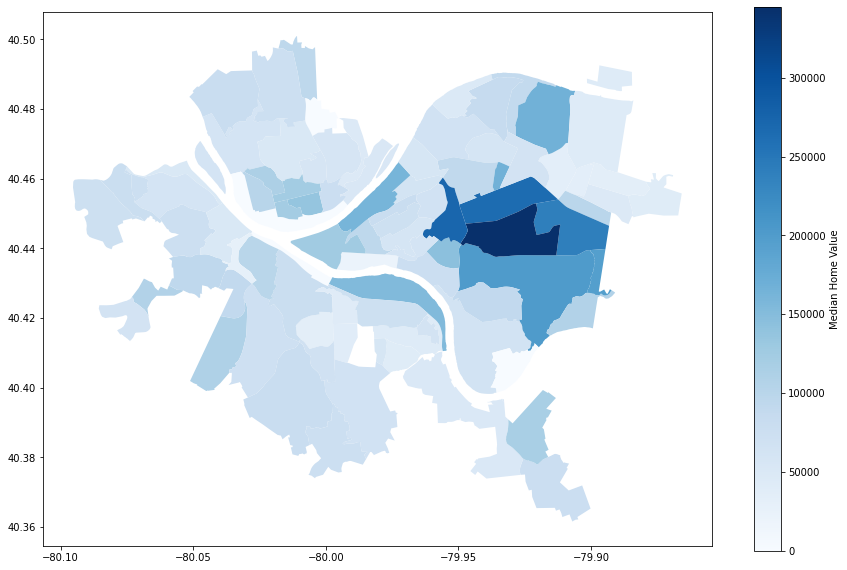

In [45]:
mhv_series = mhv_units.groupby("Neighborhood").sum()['Median Home  Value (2010)']
neighborhoods = geo.read_file("pittsburgh-pa-neighborhoods.shp")
mhv_map = neighborhoods.merge(mhv_series, how='left', left_on='hood', right_on='Neighborhood')
mhv_map.plot(column='Median Home  Value (2010)',
                    cmap='Blues',
                    figsize=(15,10),
                    legend=True,
                    legend_kwds={'label':"Median Home Value"})

---
## Established Average Years of Residence Analysis
The last metric in housing was established average years of residence, and it was analyzed using the same process as the previous metrics.



In [46]:
# Est. Avg. Years of Residence

count = 0
for x in data["Est. Avg. Yrs. of Residence (2010)"]:
    data.iloc[count, 9] = float(x)
    count+=1
    
yres_units = data.sort_values(by=["Est. Avg. Yrs. of Residence (2010)"], ascending=False).iloc[0:, 9:10]

yres_mean = float(yres_units.mean())

yres_df = pd.DataFrame(yres_units)
yres_df["Above Mean"] = np.nan

c = 0
for x in range(len(yres_df)):
    yres_temp = yres_units.iloc[x,0]
    if yres_temp > yres_mean:
        yres_df.iloc[x,1] = "Yes"
        c+=1
    else:
        yres_df.iloc[x,1] = "No"
        
yres_df["Avg. Yrs. of Residence Points"] = np.nan

for x in range(len(yres_df)):
    if(c-x > 0):
        yres_df.iloc[x,2] = (c-x)*weights.iloc[len(weights)-1, 5]
    else:
        yres_df.iloc[x,2] = 0

yres_df.head(10)

,Est. Avg. Yrs. of Residence (2010),Above Mean,Avg. Yrs. of Residence Points
Neighborhood,,,
Chartiers City,32.0,Yes,128.735632
East Carnegie,30.0,Yes,125.057471
New Homestead,19.0,Yes,121.379310
Beltzhoover,17.0,Yes,117.701149
South Shore,16.0,Yes,114.022989
Overbrook,15.5,Yes,110.344828
Lincoln Place,15.0,Yes,106.666667
Bon Air,15.0,Yes,102.988506
Allegheny West,15.0,Yes,99.310345


This is the map for established average years of residence in Pittsburgh.

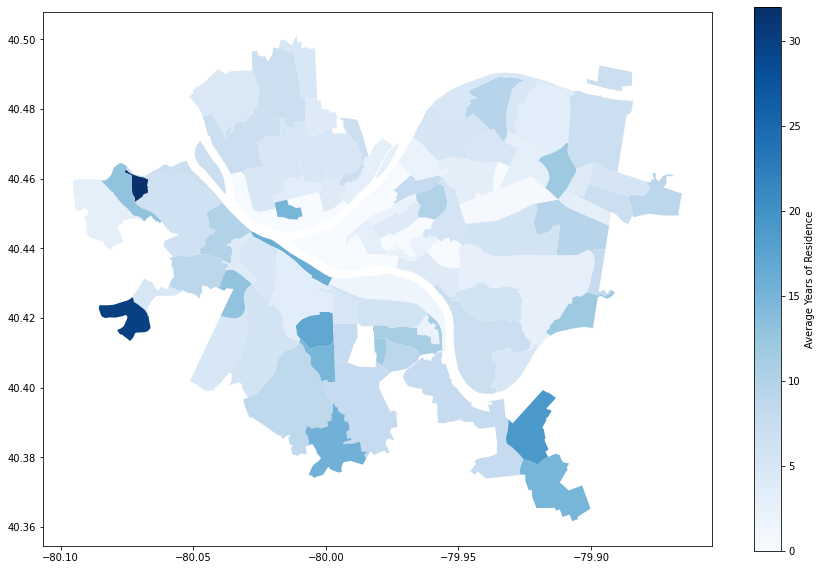

In [47]:
yres_series = yres_units.groupby("Neighborhood").sum()["Est. Avg. Yrs. of Residence (2010)"]
neighborhoods = geo.read_file("pittsburgh-pa-neighborhoods.shp")
yres_map = neighborhoods.merge(yres_series, how='left', left_on='hood', right_on='Neighborhood')
yres_map.plot(column='Est. Avg. Yrs. of Residence (2010)',
             cmap='Blues',
             figsize=(15,10),
             legend=True,
             legend_kwds={'label':"Average Years of Residence"}
             )

---
Finally, using pd.concat(), the three scores were concatenated together into one dataframe, and a new column called "Housing Final Score" simply adds up the three scores to get the final score for Housing. Here are the winners! The results were sorted by descending order of final score. Beltzhoover, Bon Air, and Larimer got the highest scores for housing!

In [48]:
housing_results = pd.concat([units_df.iloc[0:, 2:3], mhv_df.iloc[0:, 2:3],yres_df.iloc[0:,2:3]], axis=1, join='inner')
housing_results["Housing Final Score"] = np.nan
for x in range(len(housing_results)):
    housing_results.iloc[x,3] = 0
    for y in range(3):
        housing_results.iloc[x,3] += housing_results.iloc[x,y]
housing_results = housing_results.sort_values(by=["Housing Final Score"], ascending = False)
housing_results.head(10)

,Occupied Units Points,Median Home Value Points,Avg. Yrs. of Residence Points,Housing Final Score
Neighborhood,,,,
Bon Air,175.275862,78.000000,102.988506,356.264368
Beltzhoover,0.000000,216.666667,117.701149,334.367816
East Carnegie,89.885057,108.333333,125.057471,323.275862
Ridgemont,224.712644,0.000000,95.632184,320.344828
Swisshelm Park,229.206897,0.000000,88.275862,317.482759
Overbrook,143.816092,56.333333,110.344828,310.494253
Larimer,0.000000,225.333333,84.597701,309.931034
Arlington,35.954023,190.666667,77.241379,303.862069
East Hills,40.448276,208.000000,51.494253,299.942529


---

## Factor 3: Natural Environmental Conditions

### The dataset:

In [49]:
nat

,Sector #,Population (2010),Land Area (acres),Landslide Prone (% land area),Undermined (% land area),Flood Plain (% land area),# Street Trees,Park Space (acres),Park Space (% of land area),Park Space (acres/1000 pers.),Greenway (% of land area),Woodland (% of land area),Cemetery (% of land area)
Neighborhood,,,,,,,,,,,,,
Allegheny Center,3,933,134.40,0.000000,0.000000,0.001637,22,55.264,0.411190,59.232583,0.000000,0.000000,0.000000
Allegheny West,3,462,90.24,0.093273,0.000000,0.023105,229,7.182,0.079588,15.545455,0.000000,0.042354,0.000000
Allentown,6,2500,188.80,0.270911,0.903528,0.000000,87,39.385,0.208607,15.754000,0.000000,0.123093,0.000000
Arlington,7,1869,300.80,0.414182,0.572543,0.015170,79,6.747,0.022430,3.609952,0.000000,0.294289,0.073075
Arlington Heights,7,244,84.48,0.398935,0.611955,0.000000,3,0.000,0.000000,0.000000,0.000000,0.417969,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Upper Lawrenceville,13,2669,259.20,0.139144,0.000000,0.119043,246,3.252,0.012546,1.218434,0.001505,0.064356,0.000000
West End,4,254,128.00,0.167992,0.000000,0.254047,108,7.796,0.060906,30.692913,0.003680,0.132227,0.000000
West Oakland,14,2604,137.60,0.645349,0.191868,0.000000,73,1.051,0.007638,0.403610,0.000000,0.133757,0.000000


In order to properly use this data to gauge which neighborhoods are better than others we can start by sorting out the data we ought to use.

For our purposes, we will only be using the data representing percentages of land area that are covered or affected by certain things. This way, statistics will be consistent and meaningful regardless of the relative sizes of the neighborhoods.

Also, we can sort our percentage statistics into two distinct camps: Danger levels and aesthetic levels.

Danger levels are worse the higher they are, and aesthetics vice versa.

### Danger:

This will include landslide likelihood, how undermined a neighborhood is, and how much of a neighborhood is a flood plain.

These are all directly correlated with how big of a risk it is to live in said neighborhood.

In [50]:
safe1 = nat.groupby("Neighborhood").sum()['Landslide Prone (% land area)']
safe1

Neighborhood
Allegheny Center       0.000000
Allegheny West         0.093273
Allentown              0.270911
Arlington              0.414182
Arlington Heights      0.398935
                         ...   
Upper Lawrenceville    0.139144
West End               0.167992
West Oakland           0.645349
Westwood               0.152369
Windgap                0.110271
Name: Landslide Prone (% land area), Length: 90, dtype: float64

In [51]:
safe2 = nat.groupby("Neighborhood").sum()['Undermined (% land area)']
safe2

Neighborhood
Allegheny Center       0.000000
Allegheny West         0.000000
Allentown              0.903528
Arlington              0.572543
Arlington Heights      0.611955
                         ...   
Upper Lawrenceville    0.000000
West End               0.000000
West Oakland           0.191868
Westwood               0.795577
Windgap                0.000000
Name: Undermined (% land area), Length: 90, dtype: float64

In [52]:
safe3 = nat.groupby("Neighborhood").sum()['Flood Plain (% land area)']
safe3

Neighborhood
Allegheny Center       0.001637
Allegheny West         0.023105
Allentown              0.000000
Arlington              0.015170
Arlington Heights      0.000000
                         ...   
Upper Lawrenceville    0.119043
West End               0.254047
West Oakland           0.000000
Westwood               0.000000
Windgap                0.021382
Name: Flood Plain (% land area), Length: 90, dtype: float64

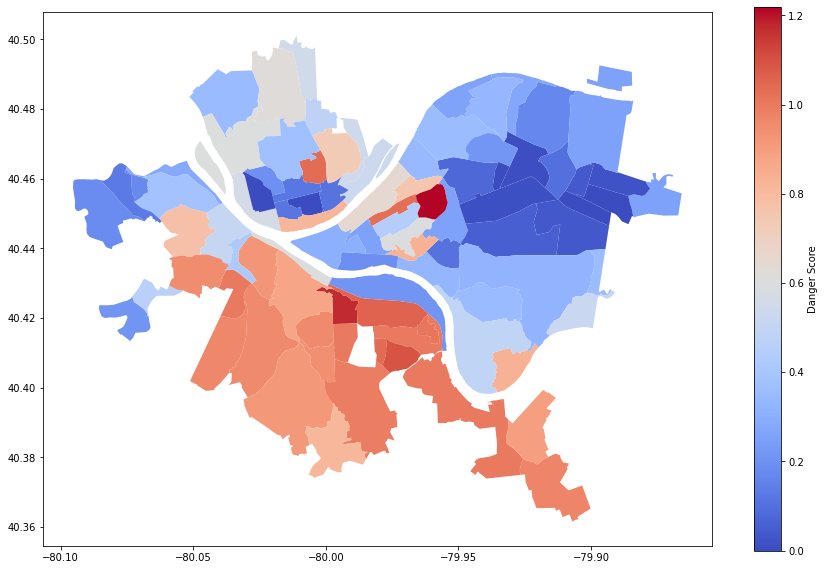

In [53]:
dangscore = pd.concat([safe1, safe2, safe3], axis = 1, join='inner')
dangscore["Danger Score"] = np.nan

for x in range(len(dangscore)):
    dangscore.iloc[x,3] = 0
    for y in range(3):
        dangscore.iloc[x,3] += dangscore.iloc[x,y]

dangchart = dangscore.groupby("Neighborhood").sum()["Danger Score"]
shape = geo.read_file("pittsburgh-pa-neighborhoods.shp")

dangmap = shape.merge(dangchart, how = 'right', left_on='hood', right_on='Neighborhood')
dangmap.plot(column="Danger Score", cmap='coolwarm', figsize=(15,10), legend=True, legend_kwds={'label': "Danger Score"})

---
We will now construct a map reflecting a cumulative "danger score," or simply the sum of all three percentage values of our "danger" data per neighborhood.

This will reflect how generally dangerous it is to live in a certain neighborhood, natural-disaster-wise.

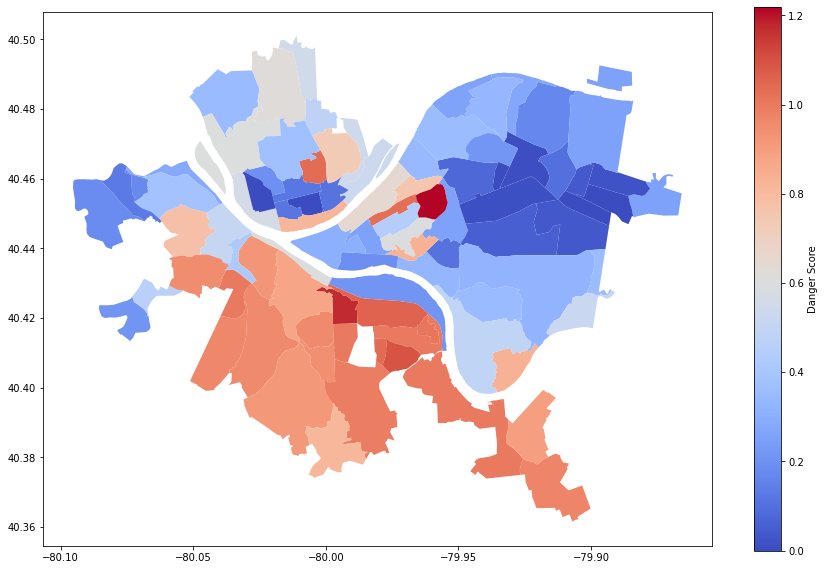

In [54]:
dangscore = pd.concat([safe1, safe2, safe3], axis = 1, join='inner')
dangscore["Danger Score"] = np.nan

for x in range(len(dangscore)):
    dangscore.iloc[x,3] = 0
    for y in range(3):
        dangscore.iloc[x,3] += dangscore.iloc[x,y]

dangchart = dangscore.groupby("Neighborhood").sum()["Danger Score"]
shape = geo.read_file("pittsburgh-pa-neighborhoods.shp")

dangmap = shape.merge(dangchart, how = 'right', left_on='hood', right_on='Neighborhood')
dangmap.plot(column="Danger Score", cmap='coolwarm', figsize=(15,10), legend=True, legend_kwds={'label': "Danger Score"})

In [55]:
dangscore = dangscore.sort_values(by=['Danger Score'], ascending = False)
dangscore

,Landslide Prone (% land area),Undermined (% land area),Flood Plain (% land area),Danger Score
Neighborhood,,,,
Upper Hill,0.385134,0.833561,0.000000,1.218695
Allentown,0.270911,0.903528,0.000000,1.174439
St. Clair,0.470877,0.618674,0.001129,1.090680
South Side Slopes,0.663595,0.397680,0.000000,1.061276
Mt. Oliver,0.092297,0.947063,0.000000,1.039359
...,...,...,...,...
Allegheny Center,0.000000,0.000000,0.001637,0.001637
Manchester,0.000000,0.000000,0.000571,0.000571
Friendship,0.000000,0.000000,0.000000,0.000000


## Aesthetics

This category includes the percentage of land area occupied by things that are generally pleasing to look at, such as parks, greenways, woodlands, and cemeteries (hey, they DO usually look pretty nice. I wouldn't call a cemetery idyllic, exactly, but they're charming.)

In [56]:
aes1 = nat.groupby("Neighborhood").sum()['Park Space (% of land area)']	
aes1

Neighborhood
Allegheny Center       0.411190
Allegheny West         0.079588
Allentown              0.208607
Arlington              0.022430
Arlington Heights      0.000000
                         ...   
Upper Lawrenceville    0.012546
West End               0.060906
West Oakland           0.007638
Westwood               0.032603
Windgap                0.043844
Name: Park Space (% of land area), Length: 90, dtype: float64

In [57]:
aes2 = nat.groupby("Neighborhood").sum()['Greenway (% of land area)']	
aes2

Neighborhood
Allegheny Center       0.000000
Allegheny West         0.000000
Allentown              0.000000
Arlington              0.000000
Arlington Heights      0.000000
                         ...   
Upper Lawrenceville    0.001505
West End               0.003680
West Oakland           0.000000
Westwood               0.000000
Windgap                0.000000
Name: Greenway (% of land area), Length: 90, dtype: float64

In [58]:
aes3 = nat.groupby("Neighborhood").sum()['Woodland (% of land area)']	
aes3

Neighborhood
Allegheny Center       0.000000
Allegheny West         0.042354
Allentown              0.123093
Arlington              0.294289
Arlington Heights      0.417969
                         ...   
Upper Lawrenceville    0.064356
West End               0.132227
West Oakland           0.133757
Westwood               0.232011
Windgap                0.232048
Name: Woodland (% of land area), Length: 90, dtype: float64

In [59]:
aes4 = nat.groupby("Neighborhood").sum()['Cemetery (% of land area)']	
aes4

Neighborhood
Allegheny Center       0.000000
Allegheny West         0.000000
Allentown              0.000000
Arlington              0.073075
Arlington Heights      0.000000
                         ...   
Upper Lawrenceville    0.000000
West End               0.000000
West Oakland           0.000000
Westwood               0.000000
Windgap                0.000000
Name: Cemetery (% of land area), Length: 90, dtype: float64

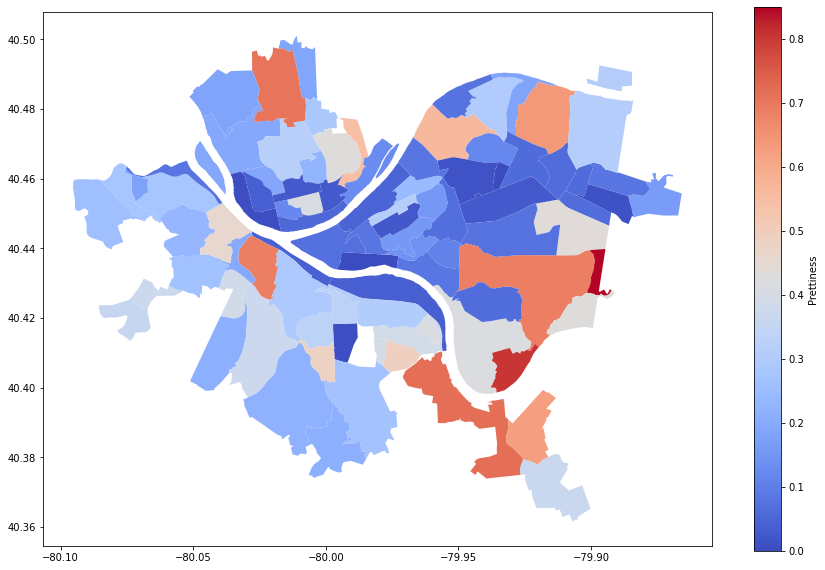

In [60]:
aesscore = pd.concat([aes1,aes2,aes3,aes4], axis = 1, join='inner')
aesscore["Prettiness"] = np.nan

for x in range(len(aesscore)):
    aesscore.iloc[x,4] = 0
    for y in range(4):
        aesscore.iloc[x,4] += aesscore.iloc[x,y]

aeschart = aesscore.groupby("Neighborhood").sum()["Prettiness"]
shape = geo.read_file("pittsburgh-pa-neighborhoods.shp")

aesmap = shape.merge(aeschart, how = 'left', left_on='hood', right_on='Neighborhood')
aesmap.plot(column="Prettiness", cmap='coolwarm', figsize=(15,10), legend=True, legend_kwds={'label': "Prettiness"})

In [61]:
aesscore = aesscore.sort_values(by=['Prettiness'], ascending = False)
aesscore

,Park Space (% of land area),Greenway (% of land area),Woodland (% of land area),Cemetery (% of land area),Prettiness
Neighborhood,,,,,
Regent Square,0.516431,0.000000,0.333203,0.000000,0.849634
Glen Hazel,0.000445,0.158881,0.646214,0.000024,0.805564
Hays,0.001128,0.000000,0.717273,0.000000,0.718401
Perry North,0.333431,0.000000,0.375705,0.000004,0.709140
Squirrel Hill South,0.400472,0.000000,0.289307,0.000000,0.689779
...,...,...,...,...,...
Homewood South,0.011460,0.000000,0.000000,0.000000,0.011460
Chateau,0.006474,0.000000,0.000000,0.000000,0.006474
Knoxville,0.000264,0.000000,0.004760,0.000000,0.005024


## Combined Scores

In order to reach our conclusion on which neighborhoods are the best on an environmental basis, we simply sum the danger and prettiness scores, but with danger as a negative value.

To interpret the sum, a greater positive final score indicates both overwhelming safety combined with copious scenery. Splendid.
A score close to zero indicates a balance between the two, perhaps great safety combined with average scenery, or awful safety combined with great scenery, which both average out to a mediocre environmental experience.
A negative score indicates a neighborhood with sights that are not worth the risk in living there, as the negative danger score outweighs however the neighborhood may look.


In [62]:
danger = dangscore.groupby("Neighborhood").sum()['Danger Score']
aesthetic = aesscore.groupby("Neighborhood").sum()['Prettiness']

danger = -danger

results = pd.concat([danger, aesthetic], axis=1, join='inner')
results["Final Score"] = np.nan

for x in range(len(results)):
    results.iloc[x,2] = 0
    for y in range(2):
        results.iloc[x,2] += results.iloc[x,y]
    
results = results.sort_values(by=['Final Score'], ascending=False)    
results

,Danger Score,Prettiness,Final Score
Neighborhood,,,
Regent Square,-0.354736,0.849634,0.494897
Highland Park,-0.167466,0.639850,0.472384
Allegheny Center,-0.001637,0.411190,0.409554
Point Breeze,-0.038068,0.435558,0.397490
Squirrel Hill South,-0.320420,0.689779,0.369359
...,...,...,...
North Shore,-0.819585,0.055332,-0.764253
Fineview,-1.033531,0.228069,-0.805462
Allentown,-1.174439,0.331700,-0.842738


Our resulting neighborrhood winners for environmental standards come out to be:

In [63]:
results.head(10)

,Danger Score,Prettiness,Final Score
Neighborhood,,,
Regent Square,-0.354736,0.849634,0.494897
Highland Park,-0.167466,0.639850,0.472384
Allegheny Center,-0.001637,0.411190,0.409554
Point Breeze,-0.038068,0.435558,0.397490
Squirrel Hill South,-0.320420,0.689779,0.369359
Central Lawrenceville,-0.356609,0.561939,0.205330
Windgap,-0.131653,0.275892,0.144239
East Carnegie,-0.214073,0.358268,0.144195
Perry North,-0.623088,0.709140,0.086052


## Regent Square appears to be the best in terms of Natural Environmental Conditions 

---

# Final Combined Results 


In [65]:
combined_results = pd.concat([results.iloc[0:, 2:3], best_neigh.iloc[0:, 2:3], housing_results.iloc[0:,3:4]], axis=1, join='inner')
combined_results["Combined"] = np.nan
for x in range (len(results)):
    combined_results.iloc[x,3] = combined_results.iloc[x,0] - combined_results.iloc[x,1] + combined_results.iloc[x,2];
combined_results = combined_results.sort_values(by=['Combined'], ascending = False)
combined_results.head(8)

,Final Score,Crime Scores,Housing Final Score,Combined
Neighborhood,,,,
Bon Air,-0.464956,20.0,356.264368,335.799412
East Carnegie,0.144195,5.0,323.275862,318.420057
Ridgemont,-0.617336,5.0,320.344828,314.727492
Swisshelm Park,-0.089684,6.0,317.482759,311.393074
New Homestead,-0.273796,4.0,292.160920,287.887124
Chartiers City,-0.003456,7.0,279.931035,272.927578
Arlington,-0.612101,39.0,303.862069,264.249968
Lincoln Place,-0.609905,14.0,271.827586,257.217681


# Bon Air in First
## East Carnegie in Second
### Ridgemont in Third

---